In [9]:
import numpy as np

from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

from matplotlib import pyplot as plt

import reciprocalspaceship as rs
import gemmi

import masks

## data loading

In [103]:
# parameters

PDB = '/Users/tjlane/Desktop/PL-workshop/DEDs-svd/Super_dark_swissFEL_refine_33.pdb'

LOW_RES =   2.5
HIGH_RES = 25.0

#MASK = lambda map : map  ; MASK_NAME = 'none'
#MASK = lambda map : masks.mask_solvent(PDB, map)  ; MASK_NAME = 'solvent'
MASK = masks.TT_chainA_region_only  ; MASK_NAME = 'TT region'
#MASK = masks.FDA_chainA_region_only  ; MASK_NAME = 'FAD region'
#MASK = masks.FDA_and_TT_chainA_region_only  ; MASK_NAME = 'TT+FAD region'

STANDARDIZE = True # set map to zero mean, 1 std

In [104]:
base_path = '/Users/tjlane/Desktop/PL-workshop/DEDs-svd/'

timepoints = {
         3.0 : '3ps_LIGHT_staraniso_unityDO_Rfree_mkFoFo.mtz',
       300.0 : '300ps_LIGHT_staraniso_unityDORfree_mkFoFo.mtz',
      1000.0 : '1ns_LIGHT_staraniso_unity_mkFoFo.mtz',
      3000.0 : '3ns_unity_LIGHT_staraniso_darkrefinedmodel-merged-aniso_mkFoFo.mtz',
     10000.0 : '10ns_light_new_EDITED-SP_celledited_staraniso_mkFoFo.mtz',
     30000.0 : '30ns_LIGHT_staraniso_unityDORfree_mkFoFo.mtz',
   1000000.0 : '1us_LIGHT_staraniso_unity_DORfree_mkFoFo.mtz',
  10000000.0 : '10us_LIGHT_staraniso_unity_DORfree_mkFoFo.mtz',
 100000000.0 : '100us_LIGHT_staraniso_unity_DORfree_mkFoFo.mtz' ,
}

for k in timepoints.keys():
    timepoints[k] = base_path + timepoints[k]

In [105]:
def cut_res(df, h_res, l_res):
    ds.compute_dHKL(inplace=True)
    df = df.loc[(df['dHKL'] >= h_res) & (df['dHKL'] <= l_res)]
    return df

def standardize_map(map):
    return (map - map.mean()) / map.std()

In [106]:
# load all Fs and sigFs into one big rs table
tps = sorted(timepoints.keys())
maps = []

for tp in tps:

    ds = rs.read_mtz(timepoints[tp]) 
    ds.compute_dHKL(inplace=True)

    ds = cut_res(ds, LOW_RES, HIGH_RES)

    grid = ds.to_gemmi().transform_f_phi_to_map('KFOFOWT', 'PHIKFOFOWT', sample_rate=3)

    if STANDARDIZE:
        map = standardize_map(map)
        
    map = np.array( MASK( grid ) )
    maps.append(map.flatten())

    fraction_of_zeros = np.sum(map == 0) / float(np.product(map.shape))
    print( np.min(ds['dHKL']), np.max(ds['dHKL']), fraction_of_zeros)

maps = np.array(maps)
print(maps.shape)

2.5000052 24.612986 0.9939128943758574
2.5000052 24.612986 0.9939128943758574
2.5000052 24.612986 0.9939128943758574
2.5000052 24.612986 0.9939128943758574
2.5000052 24.612986 0.9939128943758574
2.5000052 24.612986 0.9939128943758574
2.5000052 24.612986 0.9939128943758574
2.5000052 24.612986 0.9939128943758574
2.5000052 24.612986 0.9939128943758574
(9, 2799360)


## and try SVD

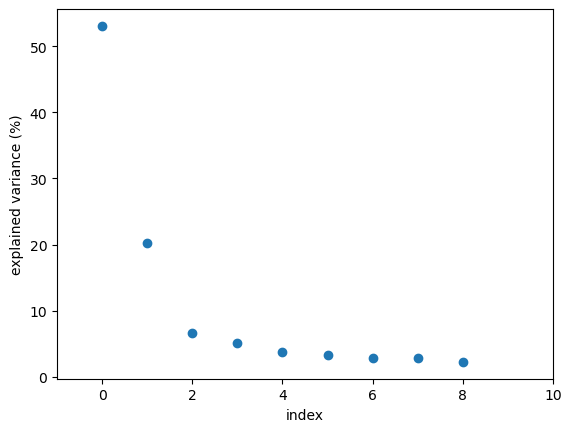

In [107]:
U, S, Vh = np.linalg.svd(maps, full_matrices=False)

plt.figure()
plt.plot(np.square(S) / np.sum(np.square(S)) * 100.0, 'o')
plt.xlabel('index')
plt.ylabel('explained variance (%)')
plt.xlim([-1, 10])
plt.show()

(90, 144, 216) (9, 9) (9, 2799360)


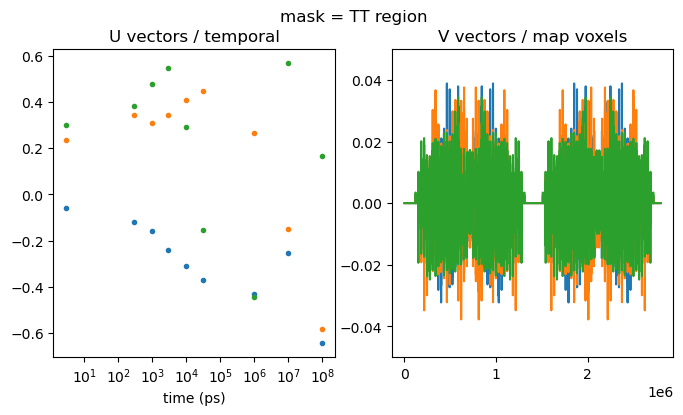

In [108]:
n = 3 # number of components to plot

print(map.shape, U.shape, Vh.shape)

plt.figure(figsize=(8,4))
plt.suptitle(f'mask = {MASK_NAME}')

axL = plt.subplot(121)
axL.plot(np.array(tps), U[:,:n] + 0.07 * np.arange(n)[None,:], '.')

plt.title('U vectors / temporal')
plt.xlabel('time (ps)')
plt.xscale('symlog')

#plt.ylim([-0.2, 0.4])
#plt.xlim([1000,1.5e6])

axR = plt.subplot(122)
axR.plot(Vh[:n,:].T)
plt.title('V vectors / map voxels')
plt.ylim([-0.05, 0.05])

plt.show()

/var/folders/s9/bht_sc9n7ys6m0q3h_3htntc0000gn/T/ipykernel_39235/3172758848.py:12: RuntimeWarning: overflow encountered in exp
  expntl = lambda t,a,b,c: a * np.exp(-b*t) + c


[ 3.26639967e-01  1.22717460e-04 -4.27564257e-01]


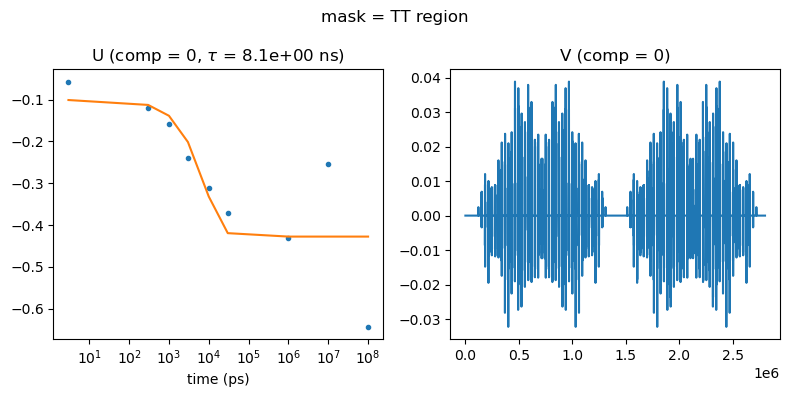

In [112]:
SAVE = False

component = 0
sign      = 1
cut_last  = 0


if cut_last:
    x = np.array(tps)[:-cut_last]
    y = sign * U[:-cut_last, component]
else:
    x = np.array(tps)[:]
    y = sign * U[:, component]

expntl = lambda t,a,b,c: a * np.exp(-b*t) + c
p_opt, _ = curve_fit(expntl,  x,  y,  p0=(0.1, 1e-3, 0.0))
print(p_opt)

# ---- plotting

plt.figure(figsize=(8,4))

axL = plt.subplot(121)
axL.plot(x, y, '.')
axL.plot(x, expntl(x, *p_opt))

plt.title(r'U (comp = %d, $\tau$ = %.1e ns)' % (component, 1e-3/p_opt[1]))
plt.suptitle(f'mask = {MASK_NAME}')
axL.set_xlabel('time (ps)')
axL.set_xscale('symlog')

axR = plt.subplot(122)
axR.plot(sign * Vh[component,:].T)
plt.title('V (comp = %d)' % component)


plt.tight_layout()

if SAVE:
    plt.savefig('figures/svd_mask-%s-%dth_comp.pdf' % (MASK_NAME, component))
    

plt.show()